# Library

In [1]:
#Modifikasi
import warnings
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
pd.set_option('display.max_columns', 100)

#Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px
import plotly.subplots as sp
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams

#Perhitungan
import itertools
from statsmodels.formula.api import ols
import statsmodels.api as sm
from geopy.geocoders import Nominatim
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

#Imputasi
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Modeling
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, GroupKFold,KFold, TimeSeriesSplit   
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc,roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data

In [32]:
df = pd.read_csv('train_adikara2024.csv')
test = pd.read_csv('test_adikara2024_unlabeled.csv')

# Exploration


In [33]:
df.head()

,id,Country,Year,Month,FoodPriceIndex
0,3501,Mexico,1971,11,0.0
1,60601,South Africa,2002,7,43.9
2,64399,Japan,2004,8,89.8
3,24227,France,1983,1,48.9
4,63779,Japan,2004,4,90.2


In [34]:
df.shape, test.shape

((11616, 5), (2640, 4))

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11616 entries, 0 to 11615
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11616 non-null  int64  
 1   Country         11616 non-null  object 
 2   Year            11616 non-null  int64  
 3   Month           11616 non-null  int64  
 4   FoodPriceIndex  11268 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 453.9+ KB


In [36]:
df.describe()

,id,Year,Month,FoodPriceIndex
count,11616.000000,11616.000000,11616.000000,11268.000000
mean,40919.409091,1991.500000,6.500000,54.084543
std,23626.188200,12.698972,3.452201,30.192230
min,7.000000,1970.000000,1.000000,0.000000
25%,20464.250000,1980.750000,3.750000,29.875000
50%,40921.500000,1991.500000,6.500000,60.300000
75%,61378.750000,2002.250000,9.250000,78.200000
max,81836.000000,2013.000000,12.000000,105.700000


In [37]:
df.columns

Index(['id', 'Country', 'Year', 'Month', 'FoodPriceIndex'], dtype='object')

In [38]:
for col in df.columns:
    print(f'columns {col}, mempunyai unique value sebanyak : {df[col].nunique()}')
    print('-'*100)

columns id, mempunyai unique value sebanyak : 11616
----------------------------------------------------------------------------------------------------
columns Country, mempunyai unique value sebanyak : 22
----------------------------------------------------------------------------------------------------
columns Year, mempunyai unique value sebanyak : 44
----------------------------------------------------------------------------------------------------
columns Month, mempunyai unique value sebanyak : 12
----------------------------------------------------------------------------------------------------
columns FoodPriceIndex, mempunyai unique value sebanyak : 1795
----------------------------------------------------------------------------------------------------


In [39]:
for col in test.columns:
    print(f'columns {col}, mempunyai unique value sebanyak : {test[col].nunique()}')
    print('-'*100)

columns id, mempunyai unique value sebanyak : 2640
----------------------------------------------------------------------------------------------------
columns Country, mempunyai unique value sebanyak : 22
----------------------------------------------------------------------------------------------------
columns Year, mempunyai unique value sebanyak : 10
----------------------------------------------------------------------------------------------------
columns Month, mempunyai unique value sebanyak : 12
----------------------------------------------------------------------------------------------------


In [40]:
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df.sort_values(by='date')

test['date'] = pd.to_datetime(test[['Year', 'Month']].assign(day=1))
test = test.sort_values(by='date')

Text(0.5, 0, 'columns')

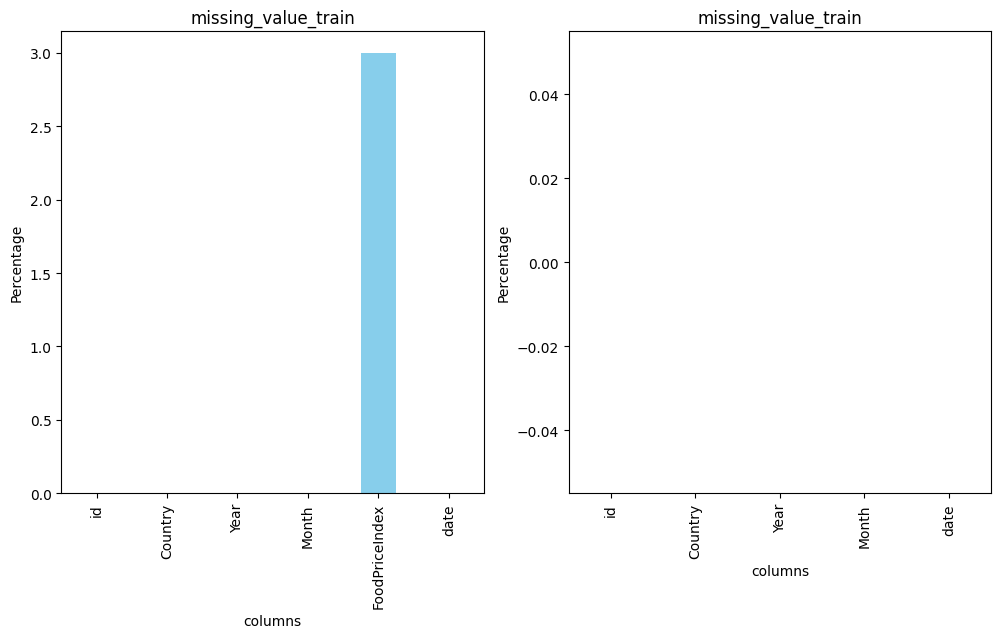

In [45]:
missing_train = (df.isna().sum() / len(df)) * 100
missing_test = (test.isna().sum() / len(test)) * 100

fig,axes = plt.subplots(1,2,figsize=(12,6))
missing_train.plot(kind='bar',ax=axes[0],color='skyblue',title='missing_value_train')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('columns')

missing_test.plot(kind='bar',ax=axes[1],color='skyblue',title='missing_value_train')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('columns')

# EDA


In [26]:
# Plot menggunakan Plotly
fig = px.line(df, x='date', y='FoodPriceIndex', title='Time Series Plot',
              labels={'date': 'Date', 'value': 'Value'}, markers=True)
fig.update_layout(
    height=700,
    width=2000,
    showlegend=False,
    title_text='Distribusi Histogram Kolom',
    title_x=0.5,
)
# Tampilkan plot
fig.show()

In [46]:
df['Country'].value_counts()

Country
Switzerland       528
France            528
Luxembourg        528
Austria           528
Denmark           528
United States     528
Italy             528
Turkey            528
Israel            528
Netherlands       528
Canada            528
South Africa      528
Germany           528
Finland           528
United Kingdom    528
Greece            528
Sweden            528
Taiwan, China     528
Mexico            528
Portugal          528
Japan             528
Spain             528
Name: count, dtype: int64

In [47]:
test['Country'].value_counts()

Country
Netherlands       120
Taiwan, China     120
Japan             120
South Africa      120
Turkey            120
Mexico            120
Austria           120
Greece            120
Denmark           120
United Kingdom    120
Spain             120
France            120
United States     120
Switzerland       120
Portugal          120
Luxembourg        120
Germany           120
Israel            120
Italy             120
Canada            120
Finland           120
Sweden            120
Name: count, dtype: int64

In [56]:
train_countries = set(df['Country'])
test_countries = set(test['Country'])

# Menampilkan negara yang ada di kedua dataset
countries_in_both = train_countries.intersection(test_countries)
countries_in_train_only = train_countries - test_countries
countries_in_test_only = test_countries - train_countries

# Menampilkan hasil
print("Negara yang ada di kedua dataset:", countries_in_both)
print("Negara yang hanya ada di data train:", countries_in_train_only)
print("Negara yang hanya ada di data test:", countries_in_test_only)


Negara yang ada di kedua dataset: {'United Kingdom', 'Japan', 'United States', 'Netherlands', 'Germany', 'Luxembourg', 'South Africa', 'Switzerland', 'Spain', 'Italy', 'Israel', 'Mexico', 'Canada', 'Finland', 'France', 'Taiwan, China', 'Greece', 'Austria', 'Denmark', 'Portugal', 'Turkey', 'Sweden'}
Negara yang hanya ada di data train: set()
Negara yang hanya ada di data test: set()


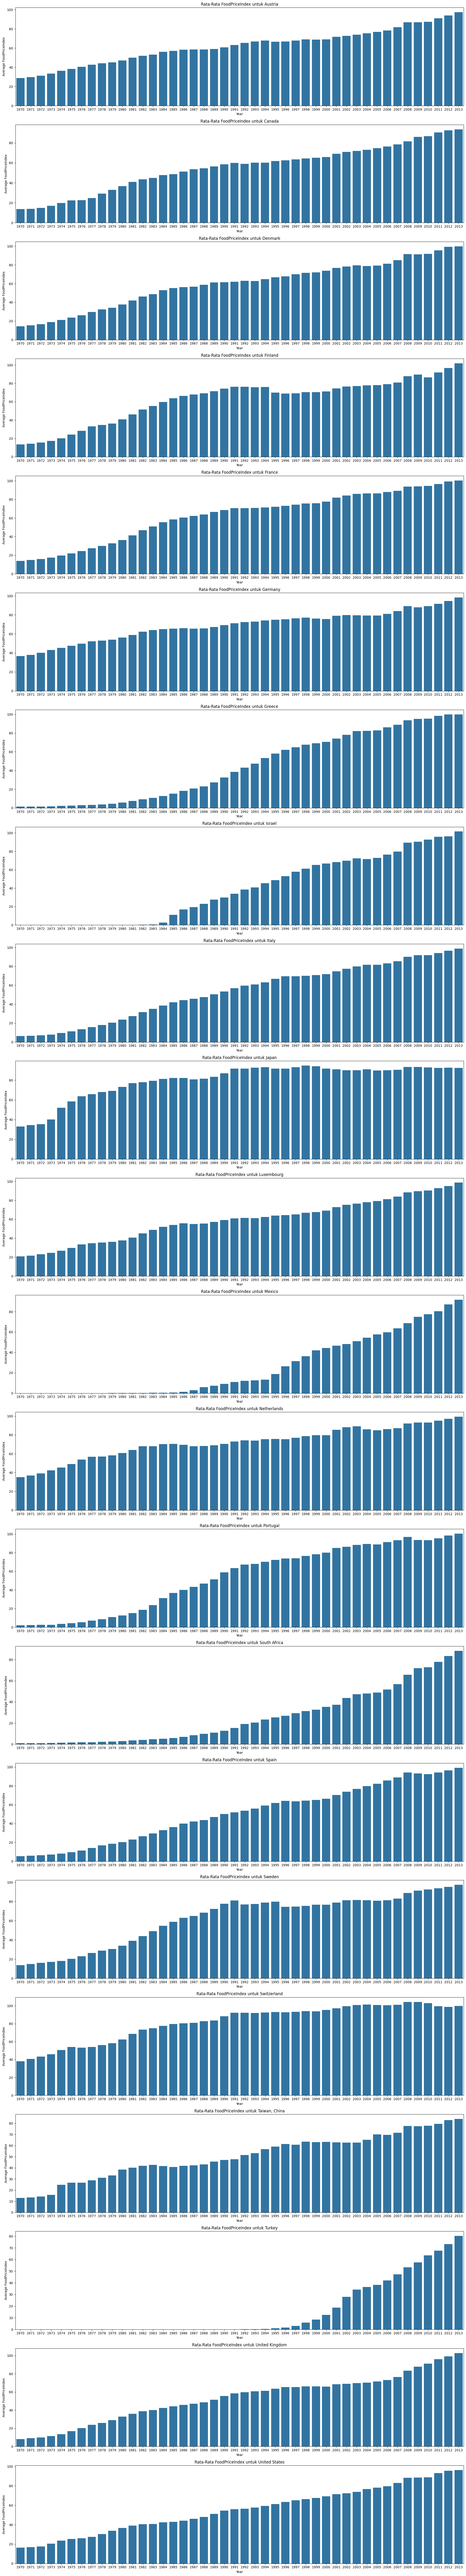

In [54]:
rata_rata = df.groupby(['Country', 'Year'])['FoodPriceIndex'].mean().reset_index()
countries = rata_rata['Country'].unique()
n_countries = len(countries)

fig, axes = plt.subplots(n_countries, 1, figsize=(20, 5 * n_countries))

# Jika hanya satu negara, axes akan berupa array dengan satu elemen, jadi periksa apakah itu array atau tidak
if n_countries == 1:
    axes = [axes]

for i, country in enumerate(countries):
    # Filter data untuk tiap negara
    country_data = rata_rata[rata_rata['Country'] == country]
    
    # Plot data untuk negara tersebut
    sns.barplot(data=country_data, x='Year', y='FoodPriceIndex', ax=axes[i])
    axes[i].set_title(f"Rata-Rata FoodPriceIndex untuk {country}")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Average FoodPriceIndex")

# Menambah jarak antar subplot agar lebih rapi
plt.tight_layout()
plt.show()

# Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

results = []  # Untuk menyimpan hasil prediksi

# Melakukan iterasi untuk setiap negara
for country in countries:
    # Filter data untuk setiap negara
    country_data = df[df['Country'] == country]
    
    # Menentukan variabel target dan fitur
    X = country_data[['Date']].copy()  # Misalnya menggunakan Date sebagai fitur
    y = country_data['FoodPriceIndex']
    
    # Mengubah 'Date' menjadi fitur numerik (misalnya timestamp)
    X['Date'] = X['Date'].values.astype(np.int64) // 10**9  # Mengubah menjadi timestamp
    
    # Membagi data menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Melatih model menggunakan RandomForestRegressor (bisa ganti dengan model lain)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Melakukan prediksi
    y_pred = model.predict(X_test)

    # Menyimpan hasil prediksi dan data terkait
    country_data_pred = X_test.copy()
    country_data_pred['True Values'] = y_test
    country_data_pred['Predicted Values'] = y_pred
    country_data_pred['Country'] = country
    results.append(country_data_pred)

    # Menampilkan metrik evaluasi untuk model
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE untuk negara {country}: {mae}")

In [58]:
from statsmodels.tsa.arima.model import ARIMA

# Membaca data
countries = df['Country'].unique()

# Menyimpan hasil prediksi
predictions = []

# Melatih model ARIMA untuk setiap negara dan melakukan prediksi
for country in countries:
    # Filter data untuk negara tertentu
    country_train_data = df[df['Country'] == country]
    country_test_data = test[test['Country'] == country]
    
    if len(country_train_data) > 1:  # Pastikan data tidak kosong
        # Membuat model ARIMA
        model = ARIMA(country_train_data['FoodPriceIndex'], order=(1, 1, 1))  # Misalnya (1,1,1)
        
        # Latih model
        model_fit = model.fit()

        # Prediksi untuk data test
        country_test_data['Predicted_FoodPriceIndex'] = model_fit.predict(start=len(country_train_data), 
                                                                          end=len(country_train_data) + len(country_test_data) - 1,
                                                                          dynamic=False)

        # Menambahkan kolom negara dan memasukkan hasil ke dalam list
        country_test_data['Country'] = country
        predictions.append(country_test_data[['Country', 'Year', 'Month', 'Predicted_FoodPriceIndex']])


# Menggabungkan semua hasil prediksi menjadi satu DataFrame
final_predictions = pd.concat(predictions)



C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method 

In [59]:
final_predictions

,Country,Year,Month,Predicted_FoodPriceIndex
262,Switzerland,2014,1,NaN
1221,Switzerland,2014,2,NaN
1741,Switzerland,2014,3,NaN
1191,Switzerland,2014,4,NaN
1940,Switzerland,2014,5,NaN
...,...,...,...,...
656,Spain,2023,8,NaN
781,Spain,2023,9,NaN
260,Spain,2023,10,NaN
1315,Spain,2023,11,NaN


In [ ]:
# Menyimpan hasil prediksi ke file CSV untuk submission Kaggle
final_predictions.to_csv('kaggle_predictions.csv', index=False)

print("Predictions saved to 'kaggle_predictions.csv'")
